# Sentence-Inference

### The problem is for every given pair of sentences ie. (sentence-1, sentence-2), determine if sentence-2 can be logically inferred given sentence-1.

## 1. Importing libraries and data

### 1.1 Importing libraries

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bs4 import BeautifulSoup
import re
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import sequence

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from difflib import SequenceMatcher

import re

from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
eng_stopwords = set(stopwords.words('english'))

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### 1.2 Importing Dataset

In [189]:
# reading training file with the data
df_train = pd.read_csv("data_set/train.csv")
df_train.head(10)

,gold_label,sentence1,sentence2
0,contradiction,A group of men with cowboy hats are watching a...,A group of women are watching a horse race
1,entailment,A kid with his head shaved sitting and holding...,Child sits with a cigarette.
2,neutral,A woman riding a bicycle past a car and a grou...,A woman riding a bicycle near a group of her f...
3,neutral,A woman looking through what appears to be a t...,An female astronamer looking toward the stars ...
4,entailment,A large group of people stand outside on a roa...,One group of people are watching what another ...
5,contradiction,A small dark-haired boy climbing in a large tree.,A small dark-haired boy is climbing over a car...
6,neutral,A man sits beside parked cars on a city street.,A man is sitting on a bench.
7,entailment,A dog looks content sitting on a bed after rip...,a dog sitting on a bed after ripping up paper.
8,contradiction,Young children and parents splashing around a ...,There are families eating lunch
9,entailment,A football coach guiding one of his players on...,The coach knows how to play football.


In [190]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9349 entries, 0 to 9348
Data columns (total 3 columns):
gold_label    9349 non-null object
sentence1     9349 non-null object
sentence2     9349 non-null object
dtypes: object(3)
memory usage: 219.2+ KB


In [191]:
df_train.shape

(9349, 3)

In [192]:
# checking if there any missing value in the dataset
df_train.isna().any()

gold_label    False
sentence1     False
sentence2     False
dtype: bool

In [193]:
# checking the total number of classes for the target variable
df_train.gold_label.value_counts()

entailment       3166
contradiction    3114
neutral          3069
Name: gold_label, dtype: int64

### NOTE: the data seems to be balanced with no missing values. <br> Now, I can proceed with data cleaning. 

## 2. Cleaning Data 

In [194]:
# I have used a custom list of stop words which do not have exceptional strings like 'no', 'nor', 'not'
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [195]:
def decontracted(phrase):
    '''
     Here is this function I will replace the words which has short hand representation of two words added together, 
     like won't is represtative of would not, etc. to the full hand representations of them.
    '''
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [196]:
def clean_text(sentance):
    '''
    Here is this function I will clean the data by following the steps:
    * remove the hyperlinks like http://...
    * Remove the HTML and XML tags using BeautifulSoup library.
    * removing white spaces and numerical values.
    * keeping only ascii characters.
    * and finally removing all stopwords from the text and making all characters to lowercase.
    '''
    
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    return sentance.strip()

In [197]:
# data before cleaning
df_train.head(10)

,gold_label,sentence1,sentence2
0,contradiction,A group of men with cowboy hats are watching a...,A group of women are watching a horse race
1,entailment,A kid with his head shaved sitting and holding...,Child sits with a cigarette.
2,neutral,A woman riding a bicycle past a car and a grou...,A woman riding a bicycle near a group of her f...
3,neutral,A woman looking through what appears to be a t...,An female astronamer looking toward the stars ...
4,entailment,A large group of people stand outside on a roa...,One group of people are watching what another ...
5,contradiction,A small dark-haired boy climbing in a large tree.,A small dark-haired boy is climbing over a car...
6,neutral,A man sits beside parked cars on a city street.,A man is sitting on a bench.
7,entailment,A dog looks content sitting on a bed after rip...,a dog sitting on a bed after ripping up paper.
8,contradiction,Young children and parents splashing around a ...,There are families eating lunch
9,entailment,A football coach guiding one of his players on...,The coach knows how to play football.


In [198]:
for i in tqdm(range(len(df_train)), position=0, leave=True):
    df_train.sentence1[i] = clean_text(df_train.sentence1[i])
    df_train.sentence2[i] = clean_text(df_train.sentence2[i])

100%|████████████████████████████████████████████████████████████████████████████| 9349/9349 [00:09<00:00, 1012.46it/s]


In [199]:
# data after cleaning
df_train.head(10)

,gold_label,sentence1,sentence2
0,contradiction,group men cowboy hats watching rodeo,group women watching horse race
1,entailment,kid head shaved sitting holding lit cigarette,child sits cigarette
2,neutral,woman riding bicycle past car group people sid...,woman riding bicycle near group friends sidewalk
3,neutral,woman looking appears telescope,female astronamer looking toward stars telescope
4,entailment,large group people stand outside road people h...,one group people watching another group
5,contradiction,small dark haired boy climbing large tree,small dark haired boy climbing car seat
6,neutral,man sits beside parked cars city street,man sitting bench
7,entailment,dog looks content sitting bed ripping paper,dog sitting bed ripping paper
8,contradiction,young children parents splashing around public...,families eating lunch
9,entailment,football coach guiding one players,coach knows play football


In [200]:
df_train['gold_label'] = df_train['gold_label'].astype('category')

In [201]:
encoder = LabelEncoder()
df_train['gold_label_encoded'] = encoder.fit_transform(df_train['gold_label'])
df_train.head(10)

,gold_label,sentence1,sentence2,gold_label_encoded
0,contradiction,group men cowboy hats watching rodeo,group women watching horse race,0
1,entailment,kid head shaved sitting holding lit cigarette,child sits cigarette,1
2,neutral,woman riding bicycle past car group people sid...,woman riding bicycle near group friends sidewalk,2
3,neutral,woman looking appears telescope,female astronamer looking toward stars telescope,2
4,entailment,large group people stand outside road people h...,one group people watching another group,1
5,contradiction,small dark haired boy climbing large tree,small dark haired boy climbing car seat,0
6,neutral,man sits beside parked cars city street,man sitting bench,2
7,entailment,dog looks content sitting bed ripping paper,dog sitting bed ripping paper,1
8,contradiction,young children parents splashing around public...,families eating lunch,0
9,entailment,football coach guiding one players,coach knows play football,1


## Data Visualization

In [202]:
avg_length_s1 = df_train['sentence1'].apply(lambda x: len(x.split(" "))).mean()
avg_length_s2 = df_train['sentence2'].apply(lambda x: len(x.split(" "))).mean()
print("Average Length of sentence 1: ", avg_length_s1)
print("Average Length of sentence 2: ", avg_length_s2)

Average Length of sentence 1:  7.985239063001391
Average Length of sentence 2:  4.091774521339181


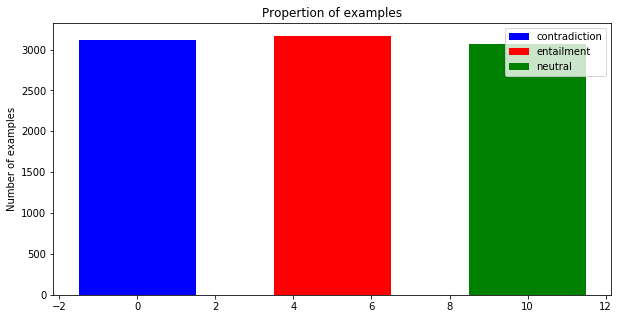

In [203]:
contradiction_len = df_train[df_train['gold_label'] == 'contradiction'].shape[0]
entailment_len = df_train[df_train['gold_label'] == 'entailment'].shape[0]
neutral_len = df_train[df_train['gold_label'] == 'neutral'].shape[0]

plt.rcParams['figure.figsize'] = (10, 5)
plt.bar(0,contradiction_len,3, label="contradiction", color='blue')
plt.bar(5,entailment_len,3, label="entailment", color='red')
plt.bar(10,neutral_len,3, label="neutral", color='green')

plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [204]:
def length(text):    
    return len(text)

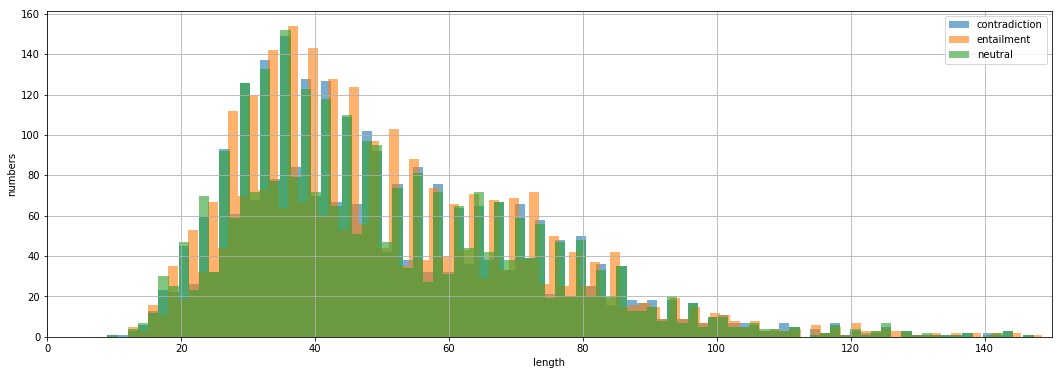

In [205]:
df_train['length_s1'] = df_train['sentence1'] .apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df_train[df_train['gold_label'] == 'contradiction']['length_s1'], alpha = 0.6, bins=bins, label='contradiction')
plt.hist(df_train[df_train['gold_label'] == 'entailment']['length_s1'], alpha = 0.6, bins=bins, label='entailment')
plt.hist(df_train[df_train['gold_label'] == 'neutral']['length_s1'], alpha = 0.6, bins=bins, label='neutral')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

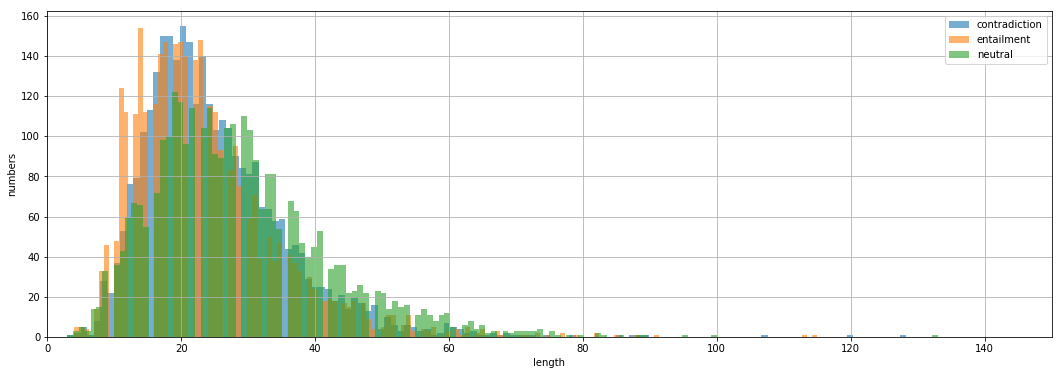

In [206]:
df_train['length_s2'] = df_train['sentence2'] .apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df_train[df_train['gold_label'] == 'contradiction']['length_s2'], alpha = 0.6, bins=bins, label='contradiction')
plt.hist(df_train[df_train['gold_label'] == 'entailment']['length_s2'], alpha = 0.6, bins=bins, label='entailment')
plt.hist(df_train[df_train['gold_label'] == 'neutral']['length_s2'], alpha = 0.6, bins=bins, label='neutral')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

<hr>

## Feature Engineering

In [213]:
# def cal_correct(df, col, threshold):
#     df[col + '_predicted'] = df[col] >= threshold
#     df[col + '_correct'] = df[col + '_predicted'] == df['gold_label_encoded']
    
#     df_group = df.groupby(df[col + '_correct']).size().reset_index()
#     df_group.columns = ['correct', 'cnt']

#     plt.pie(df_group['cnt'].tolist(), labels=df_group['correct'].tolist(), autopct='%1.1f%%')
#     plt.show()
    
# thresholds = [0.4, 0.5, 0.6]

In [214]:
def seq_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
def seq_match_df(df_data):
    col1 = 'sentence1'
    col2 = 'sentence2'
    df_data[col1] = df_data[col1].str.replace(r'\d', '')
    df_data[col2] = df_data[col2].str.replace(r'\d', '')
    df_data['seq_sim'] = 0
    df_data['seq_sim'] = df_data.apply(lambda x: seq_similarity(x[col1], x[col2]), axis=1)
    return df_data

df_result_seq = seq_match_df(df_train)

In [215]:
# for x in thresholds:
#     print('threshold:', x)
#     cal_correct(df_result_seq, 'seq_sim', x)

In [216]:
vectorizer = text.TfidfVectorizer()

def cosine_sim(test1, test2):
    tfidf = vectorizer.fit_transform([test1, test2])
    result = ((tfidf * tfidf.T).A)[0,1]
    return result
    
def cosine_sim_df(df_data):
    col1 = 'sentence1'
    col2 = 'sentence2'
    df_data[col1] = df_data[col1].str.replace(r'\d', '')
    df_data[col2] = df_data[col2].str.replace(r'\d', '')
    df_data['cos_sim'] = 0
    df_data['cos_sim'] = df_data.apply(lambda x: cosine_sim(x[col1], x[col2]), axis=1)
    return df_data

df_result_cos = cosine_sim_df(df_train)

In [217]:
# for x in thresholds:
#     print('threshold:', x)
#     cal_correct(df_result_cos, 'cos_sim', x)

### Unigram

In [218]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

df_train["unigrams_s1"] = df_train['sentence1'].apply(lambda x: get_unigrams(str(x)))
df_train["unigrams_s2"] = df_train['sentence2'].apply(lambda x: get_unigrams(str(x)))

In [219]:
## Finding the intersection between two series in pandas and return len.
def get_common_unigrams(row):
    return len( set(row["unigrams_s1"]).intersection(set(row["unigrams_s2"])) ) 

df_train["unigrams_common_count"] = df_train.apply(lambda row: get_common_unigrams(row), axis=1)

In [220]:
def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_s1"]).union(set(row["unigrams_s2"]))), 1)

df_train["unigrams_common_ratio"] = df_train.apply(lambda row: get_common_unigram_ratio(row),axis=1)

### Bigram

In [221]:
def get_bigrams(que):
    return [ i for i in ngrams(que,2)]

df_train["bigrams_s1"] = df_train["unigrams_s1"].apply(lambda x: get_bigrams(x))
df_train["bigrams_s2"] = df_train["unigrams_s2"].apply(lambda x: get_bigrams(x))

In [222]:
def get_common_bigrams(row):
    return len( set(row['bigrams_s1']).intersection(set(row['bigrams_s2'])) )

df_train["bigrams_common_count"] = df_train.apply(lambda row: get_common_bigrams(row), axis=1)

In [223]:
def get_common_bigram_ratio(row):
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_s1"]).union(set(row["bigrams_s2"]))), 1)

df_train["bigrams_common_ratio"] = df_train.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [ ]:
# train_data_features_2 = vectorizer.fit_transform(X_train["sentence2"])
# train_data_features_2 = train_data_features_2.toarray()
# print(train_data_features_2.shape)

# train_data_features_1 = vectorizer.fit_transform(X_train['sentence1'])
# train_data_features_1 = train_data_features_1.toarray()
# print(train_data_features_1.shape)

# train_data_features_12 = np.stack((train_data_features_1, train_data_features_2), axis=0) 
# print(train_data_features_12.shape)

# train_data_features_12 = train_data_features_12.reshape(train_data_features_1.shape[0], -1)
# print(train_data_features_12.shape)

In [ ]:
# test_data_features_2 = vectorizer.fit_transform(X_test["sentence2"])
# test_data_features_2 = test_data_features_2.toarray()
# print(test_data_features_2.shape)

# test_data_features_1 = vectorizer.fit_transform(X_test['sentence1'])
# test_data_features_1 = test_data_features_1.toarray()
# print(test_data_features_1.shape)

# test_data_features_12 = np.stack((test_data_features_1, test_data_features_2), axis=0) 
# print(test_data_features_12.shape)

# test_data_features_12 = test_data_features_12.reshape(test_data_features_1.shape[0], -1)
# print(test_data_features_12.shape)

In [ ]:
# vocab = vectorizer.get_feature_names()
# print(vocab)

In [224]:
df_train.head(3)

,gold_label,sentence1,sentence2,gold_label_encoded,length_s1,length_s2,seq_sim,cos_sim,unigrams_s1,unigrams_s2,unigrams_common_count,unigrams_common_ratio,bigrams_s1,bigrams_s2,bigrams_common_count,bigrams_common_ratio
0,contradiction,group men cowboy hats watching rodeo,group women watching horse race,0,36,31,0.626866,0.225765,"[group, men, cowboy, hats, watching, rodeo]","[group, women, watching, horse, race]",2,0.222222,"[(group, men), (men, cowboy), (cowboy, hats), ...","[(group, women), (women, watching), (watching,...",0,0.000000
1,entailment,kid head shaved sitting holding lit cigarette,child sits cigarette,1,45,20,0.492308,0.125367,"[kid, head, shaved, sitting, holding, lit, cig...","[child, sits, cigarette]",1,0.111111,"[(kid, head), (head, shaved), (shaved, sitting...","[(child, sits), (sits, cigarette)]",0,0.000000
2,neutral,woman riding bicycle past car group people sid...,woman riding bicycle near group friends sidewalk,2,51,48,0.808081,0.505606,"[woman, riding, bicycle, past, car, group, peo...","[woman, riding, bicycle, near, group, friends,...",5,0.500000,"[(woman, riding), (riding, bicycle), (bicycle,...","[(woman, riding), (riding, bicycle), (bicycle,...",2,0.181818


In [225]:
df_X = df_train.drop(['gold_label', 'sentence1', 'sentence2', 'unigrams_s1',
                      'unigrams_s2', 'bigrams_s1', 'bigrams_s2', 'gold_label_encoded'], axis=1)
df_y = df_train["gold_label_encoded"]

In [226]:
df_X.head()

,length_s1,length_s2,seq_sim,cos_sim,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio
0,36,31,0.626866,0.225765,2,0.222222,0,0.000000
1,45,20,0.492308,0.125367,1,0.111111,0,0.000000
2,51,48,0.808081,0.505606,5,0.500000,2,0.181818
3,31,48,0.658228,0.260556,2,0.250000,0,0.000000
4,62,39,0.495050,0.278891,2,0.166667,1,0.076923


In [227]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [228]:
X_train.shape

(7479, 8)

In [229]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=1)
pp = RF.fit(X_train, y_train)

In [230]:
predictions = RF.predict(X_test)

In [231]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))

[[264 146 205]
 [164 303 170]
 [228 169 221]]


In [232]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.40      0.43      0.42       615
           1       0.49      0.48      0.48       637
           2       0.37      0.36      0.36       618

   micro avg       0.42      0.42      0.42      1870
   macro avg       0.42      0.42      0.42      1870
weighted avg       0.42      0.42      0.42      1870



In [238]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("SVC",SVC()))

for name,model in models:
    kfold = KFold(n_splits=5, random_state=42)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

LR [0.49197861 0.5        0.48195187 0.51136364 0.52976589]
NB [0.44719251 0.44184492 0.44852941 0.4552139  0.43946488]
RF [0.43917112 0.44652406 0.46122995 0.45721925 0.47090301]
Dtree [0.42312834 0.4157754  0.42446524 0.43649733 0.41605351]
XGB [0.48930481 0.5040107  0.48930481 0.51336898 0.55451505]
KNN [0.4171123  0.39906417 0.42112299 0.40842246 0.42207358]
SVC [0.45053476 0.4592246  0.47058824 0.44585561 0.46822742]


In [235]:
inp = len(df_X.columns)
inp

8

In [237]:
classifier = Sequential()
classifier.add(Dense(units = inp, kernel_initializer = 'uniform', activation = 'relu', input_dim = df_X.shape[1]))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units = inp*3, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units = inp*5, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units = inp*10, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units = inp*20, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'RMSProp', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(df_X, df_y, batch_size = 10, epochs = 5)

Train on 9349 samples
Epoch 1/5
9349/9349 [==============================] - 1s 124us/sample - loss: -3.4387 - acc: 0.3388
Epoch 2/5
9349/9349 [==============================] - 1s 109us/sample - loss: -251.3880 - acc: 0.3386
Epoch 3/5
9349/9349 [==============================] - 1s 108us/sample - loss: -5531.5117 - acc: 0.3386
Epoch 4/5
9349/9349 [==============================] - 1s 110us/sample - loss: -48661.3028 - acc: 0.3389
Epoch 5/5
9349/9349 [==============================] - 1s 109us/sample - loss: -244184.7192 - acc: 0.3388


In [239]:
df_test = pd.read_csv("data_set/test.csv")
df_test.head()

,sentence1,sentence2
0,Number 13 kicks a soccer ball towards the goal...,A player fighting in a soccer game.
1,A woman walks next to a subway exit.,A woman is on here way home.
2,A man walks down the alley talking on his cell...,A man is walking down a wooded path and talkin...
3,Indian women playing musical chairs with white...,indain woman playing cricket with white woman
4,An older perhaps Asian man who is wearing a sl...,A tall human wearing
